In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
import seaborn as sns
import matplotlib.pyplot as plt
import ast

In [2]:
df = pd.read_csv("clean_data.csv")
df = df[~df['food_wheel_group'].isin(['Other'])].copy()

In [3]:
nutrient_cols = [
    'FAT (g)', 'PROT (g)', 'Calories (kcal)',
    'VITB1 (mg)', 'RIBF (mg)', 'VITB6 (mg)', 'VITB12 (µg)', 'VITD (µg)',
    'VITE (mg)', 'VITC (mg)', 'VITA (µg)',
    'Calcium (mg)', 'Iron (mg)', 'Magnesium (mg)', 'Phosphorus (mg)',
    'Potassium (mg)', 'Sodium (mg)', 'Zinc (mg)'
]

df_clean = df.dropna(subset=nutrient_cols).copy()

In [4]:
df_clean['Protein_per_kcal'] = df_clean['PROT (g)'] / (df_clean['Calories (kcal)'] + 1)
df_clean['Fat_to_Protein'] = df_clean['FAT (g)'] / (df_clean['PROT (g)'] + 1)
df_clean['Cal_to_Protein'] = df_clean['Calories (kcal)'] / (df_clean['PROT (g)'] + 1)
df_clean['Sodium_to_Potassium'] = df_clean['Sodium (mg)'] / (df_clean['Potassium (mg)'] + 1)

micro_cols = ['VITB1 (mg)', 'RIBF (mg)', 'VITB6 (mg)', 'VITB12 (µg)', 'VITD (µg)', 
              'VITE (mg)', 'VITC (mg)', 'VITA (µg)', 'Calcium (mg)', 'Iron (mg)', 
              'Magnesium (mg)', 'Phosphorus (mg)', 'Potassium (mg)', 'Zinc (mg)']
df_clean['Micronutrient_Density'] = df_clean[micro_cols].sum(axis=1) / (df_clean['Calories (kcal)'] + 1)

features = nutrient_cols + [
    'Protein_per_kcal', 'Fat_to_Protein', 'Cal_to_Protein',
    'Sodium_to_Potassium', 'Micronutrient_Density'
]

In [5]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df_clean[features])

In [6]:
sil_scores = {}
for k in range(3, 9):
    kmeans = KMeans(n_clusters=k, random_state=42)
    labels = kmeans.fit_predict(X_scaled)
    sil_scores[k] = silhouette_score(X_scaled, labels)

optimal_k = max(sil_scores, key=sil_scores.get)
print(f"Optimal number of clusters (diet types): {optimal_k} (Silhouette = {sil_scores[optimal_k]:.3f})")

Optimal number of clusters (diet types): 4 (Silhouette = 0.317)


In [7]:
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
df_clean['diet_cluster'] = kmeans.fit_predict(X_scaled)

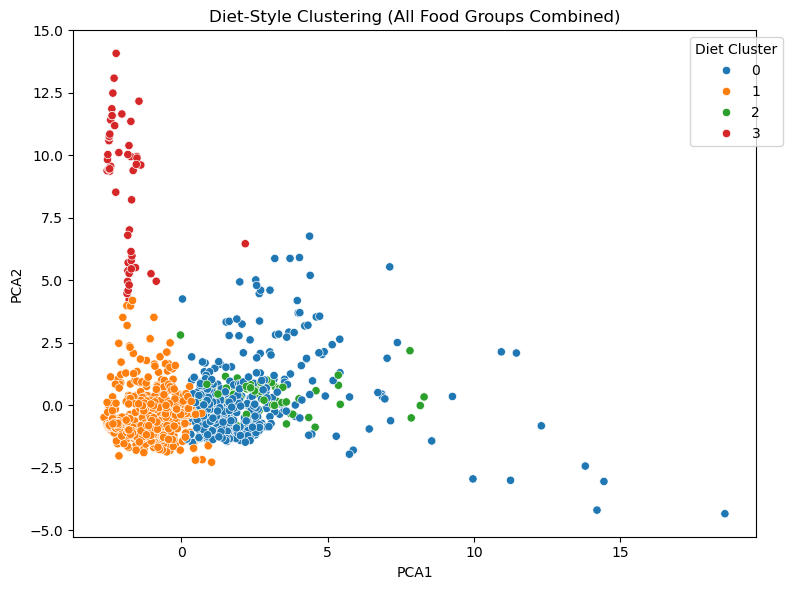

In [8]:
pca = PCA(n_components=2)
pca_result = pca.fit_transform(X_scaled)
df_clean['PCA1'] = pca_result[:, 0]
df_clean['PCA2'] = pca_result[:, 1]

plt.figure(figsize=(8,6))
sns.scatterplot(data=df_clean, x='PCA1', y='PCA2', hue='diet_cluster', palette='tab10')
plt.title("Diet-Style Clustering (All Food Groups Combined)")
plt.legend(title="Diet Cluster", bbox_to_anchor=(1.05, 1))
plt.tight_layout()
plt.show()

In [9]:
print("\n=== Diet Cluster Nutrient Profiles ===")
cluster_profiles = df_clean.groupby('diet_cluster')[features].mean().round(2)
print(cluster_profiles)

print("\n=== Food Group Composition per Diet Cluster ===")
composition = df_clean.groupby(['diet_cluster', 'food_wheel_group']).size()
display(composition)

print("\n=== Food Subgroup Composition per Diet Cluster ===")
subcomposition = df_clean.groupby(['diet_cluster', 'food_wheel_subgroup']).size()
display(subcomposition)


=== Diet Cluster Nutrient Profiles ===
              FAT (g)  PROT (g)  Calories (kcal)  VITB1 (mg)  RIBF (mg)  \
diet_cluster                                                              
0               13.66     19.07           266.56        0.32       0.31   
1                4.03      3.74           125.62        0.06       0.08   
2               21.27     24.51           318.63        0.06       0.31   
3               82.27      0.17           742.30        0.04       0.03   

              VITB6 (mg)  VITB12 (µg)  VITD (µg)  VITE (mg)  VITC (mg)  ...  \
diet_cluster                                                            ...   
0                   0.37         3.11       1.35       2.35       2.75  ...   
1                   0.08         0.12       0.12       0.85       9.86  ...   
2                   0.11         1.71       0.74       0.99       0.81  ...   
3                   0.03         0.07       3.31      19.84       0.07  ...   

              Magnesium (mg)  Phos

diet_cluster  food_wheel_group                         
0             Bread, grain/cereal products and potatoes     92
              Dairy, nuts, fish, legumes, meat and eggs    358
              Drinks                                         3
              Spreading and cooking fats                    18
              Vegetables and fruit                           8
1             Bread, grain/cereal products and potatoes    208
              Dairy, nuts, fish, legumes, meat and eggs    240
              Drinks                                       113
              Spreading and cooking fats                    26
              Vegetables and fruit                         333
2             Bread, grain/cereal products and potatoes      3
              Dairy, nuts, fish, legumes, meat and eggs     70
              Drinks                                         1
              Vegetables and fruit                           1
3             Spreading and cooking fats                    53


=== Food Subgroup Composition per Diet Cluster ===


diet_cluster  food_wheel_subgroup                      
0             Bread, grain/cereal products and potatoes     92
              Dairy                                          3
              Drinks                                         3
              Fish, legumes, meat and eggs                 321
              Fruit                                          2
              Nuts                                          34
              Spreading and cooking fats                    18
              Vegetables                                     6
1             Bread, grain/cereal products and potatoes    208
              Dairy                                        144
              Drinks                                       113
              Fish, legumes, meat and eggs                  95
              Fruit                                        111
              Nuts                                           1
              Spreading and cooking fats                    26

In [10]:
df_clean

,NEVO-code,Food group,food_name,FAT (g),PROT (g),Calories (kcal),VITB1 (mg),RIBF (mg),VITB6 (mg),VITB12 (µg),...,food_wheel_group,food_wheel_subgroup,Protein_per_kcal,Fat_to_Protein,Cal_to_Protein,Sodium_to_Potassium,Micronutrient_Density,diet_cluster,PCA1,PCA2
0,1,Potatoes and tubers,Potatoes raw,0.0,2.0,88.0,0.12,0.04,0.300,0.00,...,"Bread, grain/cereal products and potatoes","Bread, grain/cereal products and potatoes",0.022472,0.000000,29.333333,0.004435,6.229551,1,-1.056387,-0.844939
1,2,Potatoes and tubers,Potatoes new raw,0.0,2.0,88.0,0.12,0.04,0.300,0.00,...,"Bread, grain/cereal products and potatoes","Bread, grain/cereal products and potatoes",0.022472,0.000000,29.333333,0.004435,6.250112,1,-1.160073,-0.906875
2,3,Potatoes and tubers,Potatoes old raw,0.0,2.0,88.0,0.12,0.04,0.220,0.00,...,"Bread, grain/cereal products and potatoes","Bread, grain/cereal products and potatoes",0.022472,0.000000,29.333333,0.004435,6.070562,1,-1.128844,-0.813847
3,4,Cereals and cereal products,Pasta white raw,1.5,12.3,356.0,0.10,0.06,0.080,0.00,...,"Bread, grain/cereal products and potatoes","Bread, grain/cereal products and potatoes",0.034454,0.112782,26.766917,0.019802,0.831204,1,-0.395564,-0.107245
4,5,Cereals and cereal products,Rice white raw,1.0,7.0,352.0,0.04,0.03,0.120,0.00,...,"Bread, grain/cereal products and potatoes","Bread, grain/cereal products and potatoes",0.019830,0.125000,44.000000,0.019802,0.638782,1,-1.054125,-0.041871
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2318,5573,Meat substitutes and dairy substitutes,Tempeh unprepared,4.7,17.6,128.0,0.03,0.18,0.091,0.02,...,"Dairy, nuts, fish, legumes, meat and eggs","Fish, legumes, meat and eggs",0.136434,0.252688,6.881720,0.125402,5.058302,0,0.539363,-0.903534
2319,5574,Cereals and cereal products,Bakery mix for doughnuts Dutch style,1.0,11.0,367.0,0.09,0.09,0.134,0.00,...,"Bread, grain/cereal products and potatoes","Bread, grain/cereal products and potatoes",0.029891,0.083333,30.583333,4.047619,0.875826,1,-0.517407,-0.002281
2320,5575,Cheese,Cheese 35+,20.4,27.3,302.0,0.03,0.27,0.058,1.81,...,"Dairy, nuts, fish, legumes, meat and eggs",Dairy,0.090099,0.720848,10.671378,9.054795,6.209102,2,2.827626,0.204939
2321,5576,Cereals and cereal products,Flour spelt,1.7,13.2,348.0,0.21,0.03,0.088,0.00,...,"Bread, grain/cereal products and potatoes","Bread, grain/cereal products and potatoes",0.037822,0.119718,24.507042,0.000000,1.291484,1,-0.155271,-0.150120


In [11]:
def classify_diet(row):
    vegetarian_groups = [
        'Potatoes and tubers', 'Cereals and cereal products', 'Vegetables', 'Fruits',
        'Legumes', 'Nuts and seeds', 'Bread', 'Pastry and biscuits',
        'Milk and milk products', 'Cheese', 'Eggs', 'Herbs and spices',
        'Sugar, sweets and sweet sauces', 'Alcoholic beverages',
        'Non-alcoholic beverages', 'Meat substitutes and dairy substitutes',
    ]
    
    labels = row.get('diet_label', [])
    
    if isinstance(labels, str):
        labels = labels.strip()
        if labels.startswith('[') and labels.endswith(']'):
            try:
                labels = ast.literal_eval(labels)  
            except:
                labels = [labels]
        else:
            labels = [labels]
    elif labels is None:
        labels = []
    
    if row.get('Food group') in vegetarian_groups:
        if 'Vegetarian' not in labels:
            labels.append('Vegetarian')
    
    cluster = row.get('diet_cluster')
    if cluster == 0 and 'Continental Diet' not in labels:
        labels.append('Continental Diet')
    elif cluster == 1 and 'Plant-Focused Flexitarian Diet' not in labels:
        labels.append('Plant-Focused Flexitarian Diet')
    
    return list(set(labels)) if labels else np.nan

In [12]:
df_clean['diet_label'] = df_clean.apply(classify_diet, axis=1)

In [13]:
df_clean

,NEVO-code,Food group,food_name,FAT (g),PROT (g),Calories (kcal),VITB1 (mg),RIBF (mg),VITB6 (mg),VITB12 (µg),...,food_wheel_subgroup,Protein_per_kcal,Fat_to_Protein,Cal_to_Protein,Sodium_to_Potassium,Micronutrient_Density,diet_cluster,PCA1,PCA2,diet_label
0,1,Potatoes and tubers,Potatoes raw,0.0,2.0,88.0,0.12,0.04,0.300,0.00,...,"Bread, grain/cereal products and potatoes",0.022472,0.000000,29.333333,0.004435,6.229551,1,-1.056387,-0.844939,"[Vegetarian, Plant-Focused Flexitarian Diet]"
1,2,Potatoes and tubers,Potatoes new raw,0.0,2.0,88.0,0.12,0.04,0.300,0.00,...,"Bread, grain/cereal products and potatoes",0.022472,0.000000,29.333333,0.004435,6.250112,1,-1.160073,-0.906875,"[Vegetarian, Plant-Focused Flexitarian Diet]"
2,3,Potatoes and tubers,Potatoes old raw,0.0,2.0,88.0,0.12,0.04,0.220,0.00,...,"Bread, grain/cereal products and potatoes",0.022472,0.000000,29.333333,0.004435,6.070562,1,-1.128844,-0.813847,"[Vegetarian, Plant-Focused Flexitarian Diet]"
3,4,Cereals and cereal products,Pasta white raw,1.5,12.3,356.0,0.10,0.06,0.080,0.00,...,"Bread, grain/cereal products and potatoes",0.034454,0.112782,26.766917,0.019802,0.831204,1,-0.395564,-0.107245,"[Vegetarian, Plant-Focused Flexitarian Diet]"
4,5,Cereals and cereal products,Rice white raw,1.0,7.0,352.0,0.04,0.03,0.120,0.00,...,"Bread, grain/cereal products and potatoes",0.019830,0.125000,44.000000,0.019802,0.638782,1,-1.054125,-0.041871,"[Vegetarian, Plant-Focused Flexitarian Diet]"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2318,5573,Meat substitutes and dairy substitutes,Tempeh unprepared,4.7,17.6,128.0,0.03,0.18,0.091,0.02,...,"Fish, legumes, meat and eggs",0.136434,0.252688,6.881720,0.125402,5.058302,0,0.539363,-0.903534,"[Continental Diet, Vegetarian]"
2319,5574,Cereals and cereal products,Bakery mix for doughnuts Dutch style,1.0,11.0,367.0,0.09,0.09,0.134,0.00,...,"Bread, grain/cereal products and potatoes",0.029891,0.083333,30.583333,4.047619,0.875826,1,-0.517407,-0.002281,"[Vegetarian, Plant-Focused Flexitarian Diet]"
2320,5575,Cheese,Cheese 35+,20.4,27.3,302.0,0.03,0.27,0.058,1.81,...,Dairy,0.090099,0.720848,10.671378,9.054795,6.209102,2,2.827626,0.204939,[Vegetarian]
2321,5576,Cereals and cereal products,Flour spelt,1.7,13.2,348.0,0.21,0.03,0.088,0.00,...,"Bread, grain/cereal products and potatoes",0.037822,0.119718,24.507042,0.000000,1.291484,1,-0.155271,-0.150120,"[Vegetarian, Plant-Focused Flexitarian Diet]"


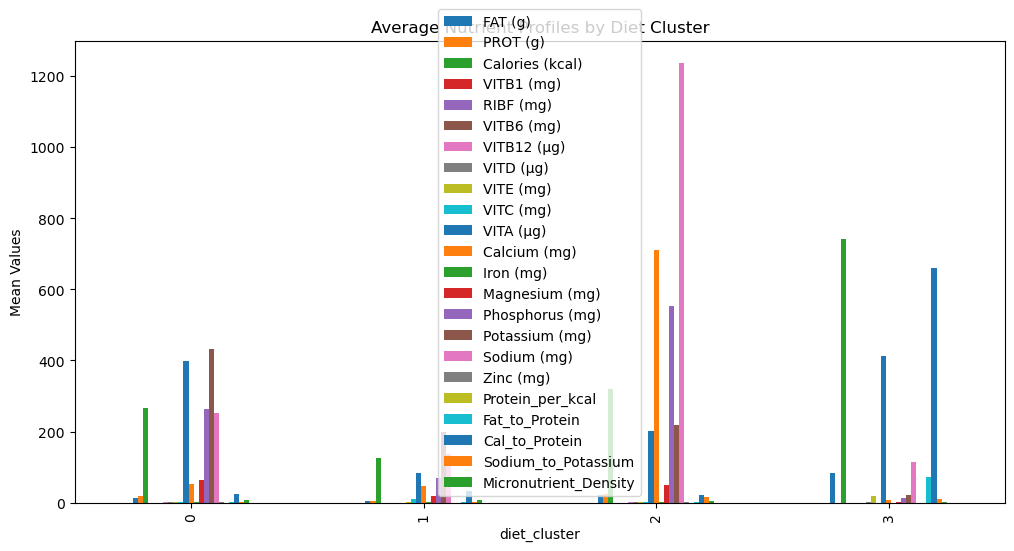

In [14]:
cluster_profiles.plot(kind='bar', figsize=(12, 6))
plt.title("Average Nutrient Profiles by Diet Cluster")
plt.ylabel("Mean Values")
plt.show()

### Add tagging for "high in {nutrient}" and "low in {nutrient}" for the top and bottom 10%

In [15]:
nutrient_cols = [
    'FAT (g)', 'PROT (g)', 'Calories (kcal)', 
    'VITB12 (µg)', 'VITD (µg)', 'VITC (mg)', 'Iron (mg)',
]

low_only = ['Calories (kcal)',  'FAT (g)']   
high_only = [n for n in nutrient_cols if n not in low_only]

high_thresholds = df_clean.groupby("food_wheel_subgroup")[nutrient_cols].quantile(0.95)
low_thresholds = df_clean.groupby("food_wheel_subgroup")[nutrient_cols].quantile(0.05)

print("=== High thresholds per subgroup ===")
print(high_thresholds)
print("\n=== Low thresholds per subgroup ===")
print(low_thresholds)

=== High thresholds per subgroup ===
                                           FAT (g)  PROT (g)  Calories (kcal)  \
food_wheel_subgroup                                                             
Bread, grain/cereal products and potatoes    20.96     14.00            448.0   
Dairy                                        33.32     30.10            401.6   
Drinks                                        1.34      1.40            226.6   
Fish, legumes, meat and eggs                 26.90     30.90            347.5   
Fruit                                         5.24      2.92            313.0   
Nuts                                         75.38     26.38            750.6   
Spreading and cooking fats                  100.00     18.36            900.0   
Vegetables                                    1.26      5.00             86.2   

                                           VITB12 (µg)  VITD (µg)  VITC (mg)  \
food_wheel_subgroup                                                     

In [16]:
def benefit_per_group(row):
    benefits = []
    subgroup = row["food_wheel_subgroup"]

    # Skip if subgroup is missing
    if pd.isna(subgroup) or subgroup not in high_thresholds.index:
        return np.nan

    for nutrient in nutrient_cols:
        val = row.get(nutrient, np.nan)
        if pd.isna(val):
            continue

        high_thr = high_thresholds.loc[subgroup, nutrient]
        low_thr = low_thresholds.loc[subgroup, nutrient]

        # High tags (everything except fat & calories)
        if nutrient in high_only and val >= high_thr:
            benefits.append(f"High in {nutrient}")

        # Low tags (fat & calories only)
        elif nutrient in low_only and val <= low_thr:
            benefits.append(f"Low in {nutrient}")

    # Return only if at least one benefit
    return benefits if benefits else np.nan

In [17]:
df_clean["benefit"] = df_clean.apply(benefit_per_group, axis=1)

df_clean.head()

,NEVO-code,Food group,food_name,FAT (g),PROT (g),Calories (kcal),VITB1 (mg),RIBF (mg),VITB6 (mg),VITB12 (µg),...,Protein_per_kcal,Fat_to_Protein,Cal_to_Protein,Sodium_to_Potassium,Micronutrient_Density,diet_cluster,PCA1,PCA2,diet_label,benefit
0,1,Potatoes and tubers,Potatoes raw,0.0,2.0,88.0,0.12,0.04,0.30,0.0,...,0.022472,0.000000,29.333333,0.004435,6.229551,1,-1.056387,-0.844939,"[Vegetarian, Plant-Focused Flexitarian Diet]","[Low in FAT (g), High in VITC (mg)]"
1,2,Potatoes and tubers,Potatoes new raw,0.0,2.0,88.0,0.12,0.04,0.30,0.0,...,0.022472,0.000000,29.333333,0.004435,6.250112,1,-1.160073,-0.906875,"[Vegetarian, Plant-Focused Flexitarian Diet]","[Low in FAT (g), High in VITC (mg)]"
2,3,Potatoes and tubers,Potatoes old raw,0.0,2.0,88.0,0.12,0.04,0.22,0.0,...,0.022472,0.000000,29.333333,0.004435,6.070562,1,-1.128844,-0.813847,"[Vegetarian, Plant-Focused Flexitarian Diet]",[Low in FAT (g)]
3,4,Cereals and cereal products,Pasta white raw,1.5,12.3,356.0,0.10,0.06,0.08,0.0,...,0.034454,0.112782,26.766917,0.019802,0.831204,1,-0.395564,-0.107245,"[Vegetarian, Plant-Focused Flexitarian Diet]",NaN
4,5,Cereals and cereal products,Rice white raw,1.0,7.0,352.0,0.04,0.03,0.12,0.0,...,0.019830,0.125000,44.000000,0.019802,0.638782,1,-1.054125,-0.041871,"[Vegetarian, Plant-Focused Flexitarian Diet]",NaN


In [18]:
df_clean_demo = df_clean[[
    'NEVO-code', 'food_name', 'FAT (g)', 'PROT (g)',
    'Calories (kcal)', 'VITB12 (µg)', 'VITD (µg)', 'VITC (mg)', 
    'Iron (mg)', 'food_wheel_group', 'food_wheel_subgroup', 
    'diet_label'
]]

In [19]:
df_clean['benefit'] = df_clean.apply(benefit_per_group, axis=1)

In [20]:
df_clean_demo['benefit'] = df_clean.apply(benefit_per_group, axis=1)

/var/folders/cr/_q1why214gg5d4kb6_zzn9mr0000gn/T/ipykernel_95087/2505004041.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_demo['benefit'] = df_clean.apply(benefit_per_group, axis=1)


In [21]:
df_clean.columns

Index(['NEVO-code', 'Food group', 'food_name', 'FAT (g)', 'PROT (g)',
       'Calories (kcal)', 'VITB1 (mg)', 'RIBF (mg)', 'VITB6 (mg)',
       'VITB12 (µg)', 'VITD (µg)', 'VITE (mg)', 'VITC (mg)', 'VITA (µg)',
       'Calcium (mg)', 'Iron (mg)', 'Magnesium (mg)', 'Phosphorus (mg)',
       'Potassium (mg)', 'Sodium (mg)', 'Zinc (mg)', 'food_wheel_group',
       'food_wheel_subgroup', 'Protein_per_kcal', 'Fat_to_Protein',
       'Cal_to_Protein', 'Sodium_to_Potassium', 'Micronutrient_Density',
       'diet_cluster', 'PCA1', 'PCA2', 'diet_label', 'benefit'],
      dtype='object')

In [22]:
# List of nutrient columns
nutrients = ['FAT (g)', 'PROT (g)', 'Calories (kcal)', 
             'VITB12 (µg)', 'VITD (µg)', 'VITC (mg)', 'Iron (mg)']

# Convert nutrient columns to numeric safely
for col in nutrients:
    df_clean_demo[col] = pd.to_numeric(df_clean_demo[col].astype(str).str.replace(',', '.'), errors='coerce')

# Filter for vegetarian ingredients
vegetarian_df = df_clean_demo[df_clean_demo['diet_label'].apply(lambda x: isinstance(x, list) and 'Vegetarian' in x)]

average_nutrients = vegetarian_df[nutrients].mean()
print("Average nutrient values for all vegetarian ingredients:\n")
for nutrient, value in average_nutrients.items():
    print(f"{nutrient}: {value:.2f}")

subgroup_counts = vegetarian_df['food_wheel_subgroup'].value_counts()
print("\nCount of vegetarian ingredients per food subgroup:\n")
print(subgroup_counts)

Average nutrient values for all vegetarian ingredients:

FAT (g): 6.43
PROT (g): 6.44
Calories (kcal): 173.04
VITB12 (µg): 0.22
VITD (µg): 0.10
VITC (mg): 8.56
Iron (mg): 1.37

Count of vegetarian ingredients per food subgroup:

food_wheel_subgroup
Bread, grain/cereal products and potatoes    303
Vegetables                                   229
Dairy                                        205
Drinks                                       117
Fruit                                        113
Fish, legumes, meat and eggs                 113
Nuts                                          37
Name: count, dtype: int64


/var/folders/cr/_q1why214gg5d4kb6_zzn9mr0000gn/T/ipykernel_95087/283240517.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_demo[col] = pd.to_numeric(df_clean_demo[col].astype(str).str.replace(',', '.'), errors='coerce')
/var/folders/cr/_q1why214gg5d4kb6_zzn9mr0000gn/T/ipykernel_95087/283240517.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_demo[col] = pd.to_numeric(df_clean_demo[col].astype(str).str.replace(',', '.'), errors='coerce')
/var/folders/cr/_q1why214gg5d4kb6_zzn9mr0000gn

In [23]:
df_clean.to_csv("final_dataset.csv", index=False)

In [24]:
df_clean_demo.to_csv("final_dataset_demo.csv", index=False)

In [25]:
df_clean_demo = pd.read_csv("final_dataset_demo.csv")

In [26]:
df_clean_demo

,NEVO-code,food_name,FAT (g),PROT (g),Calories (kcal),VITB12 (µg),VITD (µg),VITC (mg),Iron (mg),food_wheel_group,food_wheel_subgroup,diet_label,benefit
0,1,Potatoes raw,0.0,2.0,88.0,0.00,0.0,14.0,0.5,"Bread, grain/cereal products and potatoes","Bread, grain/cereal products and potatoes","['Vegetarian', 'Plant-Focused Flexitarian Diet']","['Low in FAT (g)', 'High in VITC (mg)']"
1,2,Potatoes new raw,0.0,2.0,88.0,0.00,0.0,25.0,0.5,"Bread, grain/cereal products and potatoes","Bread, grain/cereal products and potatoes","['Vegetarian', 'Plant-Focused Flexitarian Diet']","['Low in FAT (g)', 'High in VITC (mg)']"
2,3,Potatoes old raw,0.0,2.0,88.0,0.00,0.0,5.0,0.5,"Bread, grain/cereal products and potatoes","Bread, grain/cereal products and potatoes","['Vegetarian', 'Plant-Focused Flexitarian Diet']",['Low in FAT (g)']
3,4,Pasta white raw,1.5,12.3,356.0,0.00,0.0,0.0,2.0,"Bread, grain/cereal products and potatoes","Bread, grain/cereal products and potatoes","['Vegetarian', 'Plant-Focused Flexitarian Diet']",NaN
4,5,Rice white raw,1.0,7.0,352.0,0.00,0.0,0.0,0.4,"Bread, grain/cereal products and potatoes","Bread, grain/cereal products and potatoes","['Vegetarian', 'Plant-Focused Flexitarian Diet']",NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1522,5573,Tempeh unprepared,4.7,17.6,128.0,0.02,0.0,0.0,1.7,"Dairy, nuts, fish, legumes, meat and eggs","Fish, legumes, meat and eggs","['Continental Diet', 'Vegetarian']",NaN
1523,5574,Bakery mix for doughnuts Dutch style,1.0,11.0,367.0,0.00,0.0,0.0,1.0,"Bread, grain/cereal products and potatoes","Bread, grain/cereal products and potatoes","['Vegetarian', 'Plant-Focused Flexitarian Diet']",NaN
1524,5575,Cheese 35+,20.4,27.3,302.0,1.81,0.3,1.0,0.2,"Dairy, nuts, fish, legumes, meat and eggs",Dairy,['Vegetarian'],NaN
1525,5576,Flour spelt,1.7,13.2,348.0,0.00,0.0,10.8,1.6,"Bread, grain/cereal products and potatoes","Bread, grain/cereal products and potatoes","['Vegetarian', 'Plant-Focused Flexitarian Diet']",NaN


In [27]:
df_clean_demo.columns

Index(['NEVO-code', 'food_name', 'FAT (g)', 'PROT (g)', 'Calories (kcal)',
       'VITB12 (µg)', 'VITD (µg)', 'VITC (mg)', 'Iron (mg)',
       'food_wheel_group', 'food_wheel_subgroup', 'diet_label', 'benefit'],
      dtype='object')